# Wind Turbine Power Prediction

In this study we are going to predict a wind turbine power production by using the wind speed, wind direction, month and hour data.

The dataset consists of 50530 observations. In order to demonstrate my data science skills with big data, we are going to use Pyspark library.

The dataset contains:

* Date/Time (for 10 minutes intervals)
* LV ActivePower (kW): The power generated by the turbine for that moment
* Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
* TheoreticalPowerCurve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
* Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)


## Aim of the Study:

**Our aim is to predict wind turbine power production from the wind speed, wind direction, month of the year and the hour of the day.** 

## Importing Libraries and Spark Configuration

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from warnings import filterwarnings
filterwarnings('ignore')

In [7]:
# Downloading pyspark library
! pip install pyspark

In [8]:
# Importing pyspark libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext
# Configuration of Spark Session
spark = SparkSession.builder.master("local").appName("wind_turbine_project").getOrCreate()
sc = spark.sparkContext



## Reading the Dataset

In [9]:
# Reading the dataset as Spark DataFrame
spark_df = spark.read.csv('T1.csv', header=True, inferSchema=True)


# spark_df.select("Wind Speed (m/s)").show()
# print(spark_df())
# Caching the dataset
spark_df.cache()

# Converting all the column names to lower case
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])

print('Show the first 5 rows')
print(spark_df.show(5))

Show the first 5 rows
+----------------+-------------------+----------------+-----------------------------+------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|
+----------------+-------------------+----------------+-----------------------------+------------------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|
+----------------+-------------------+----------------+-----------------------------+------------------+
only showing top 5 rows

None


In [10]:
# Extracting a substring from columns to create month and hour variables

from pyspark.sql.functions import substring
spark_df = spark_df.withColumn("month", substring("date/time", 4,2))
spark_df = spark_df.withColumn("hour", substring("date/time", 12,2))
spark_df = spark_df.withColumn("day", substring("date/time", 12,2))



# Converting string month and hour variables to integer
from pyspark.sql.types import IntegerType
spark_df = spark_df.withColumn('month', spark_df.month.cast(IntegerType()))
spark_df = spark_df.withColumn('hour', spark_df.hour.cast(IntegerType()))
spark_df = spark_df.withColumn('day', spark_df.month.cast(IntegerType()))


print(spark_df.show(5))

+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+---+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|hour|day|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+---+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|   0|  1|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|   0|  1|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|   0|  1|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|   0|  1|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1|   0|  1|
+----------------+-------------------+--

## Exploratory Data Analysis

In [11]:
pd.options.display.float_format = '{:.2f}'.format
spark_df.select('wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)').toPandas().describe()

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
count,50530.00,50530.00,50530.00
mean,7.56,1492.18,1307.68
std,4.23,1368.02,1312.46
min,0.00,0.00,-2.47
25%,4.20,161.33,50.68
50%,7.10,1063.78,825.84
75%,10.30,2964.97,2482.51
max,25.21,3600.00,3618.73


### Question: What are the distributions of the variables?

**For creating visualization we need to either use aggregated data or use a sample from the big data.**

**So I will get a random sample from my big data.**

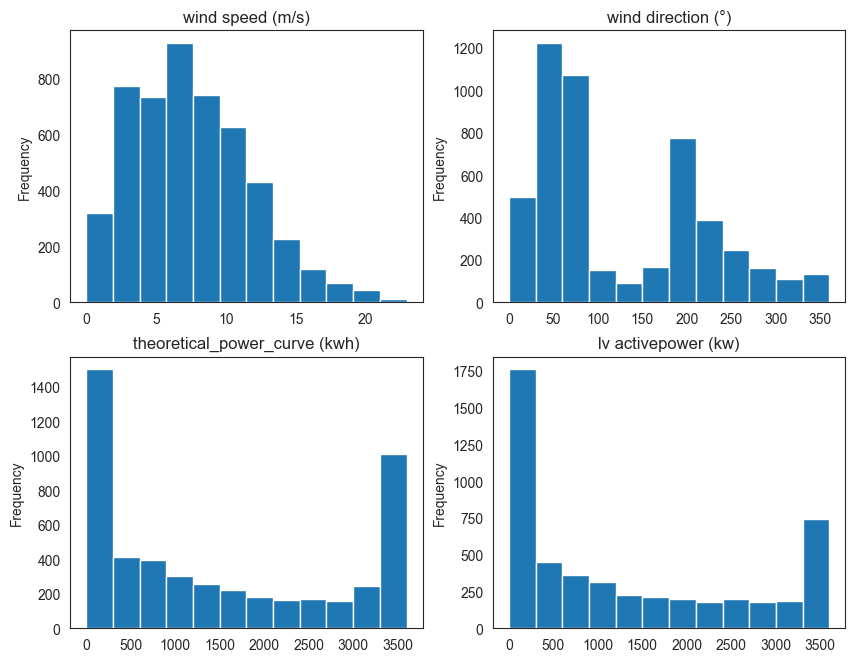

In [12]:
# Taking a random sample from the big data
sample_df = spark_df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

# Visualizing the distributions with the sample data
columns = ['wind speed (m/s)', 'wind direction (°)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(10,12))
for each in columns:
    plt.subplot(3,2,i)
    sample_df[each].plot.hist(bins=12)
    plt.title(each)      
    i += 1

### Question: Is there any difference between the months for average power production ?

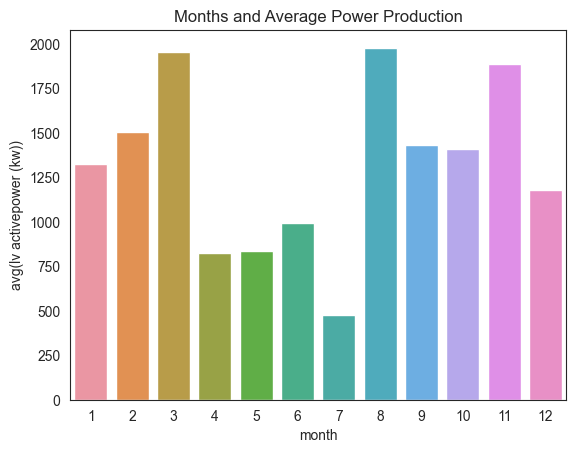

In [13]:
# Average power production by month
monthly = spark_df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly)
plt.title('Months and Average Power Production');

### Question: Is there any difference between the hours for average power production?

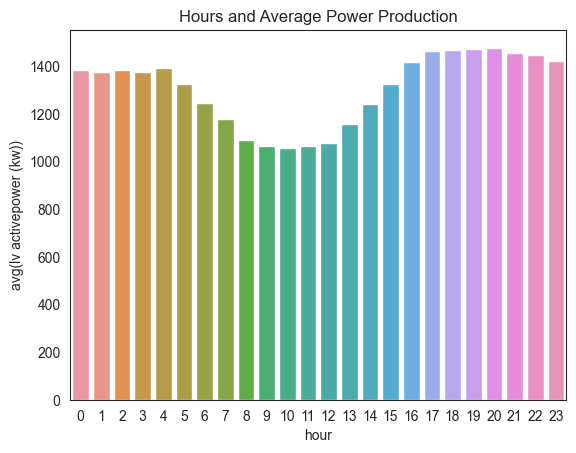

In [14]:
# Average power production by hour
hourly = spark_df.groupby('hour').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='hour', y='avg(lv activepower (kw))', data=hourly)
plt.title('Hours and Average Power Production');

### Question: Is there any correlation between the wind speed, wind direction and power production?

In [15]:
display(sample_df[columns].corr())
# sns.pairplot(sample_df[columns], markers='*');

,wind speed (m/s),wind direction (°),theoretical_power_curve (kwh),lv activepower (kw)
wind speed (m/s),1.00,-0.08,0.95,0.91
wind direction (°),-0.08,1.00,-0.11,-0.06
theoretical_power_curve (kwh),0.95,-0.11,1.00,0.94
lv activepower (kw),0.91,-0.06,0.94,1.00


**Wind speed and power production is highly correlated as one would expect.**

**We can see there are lower level power production for some wind directions.**

### Question: Does the researcher's theoritical power production curve fit well with the real production?

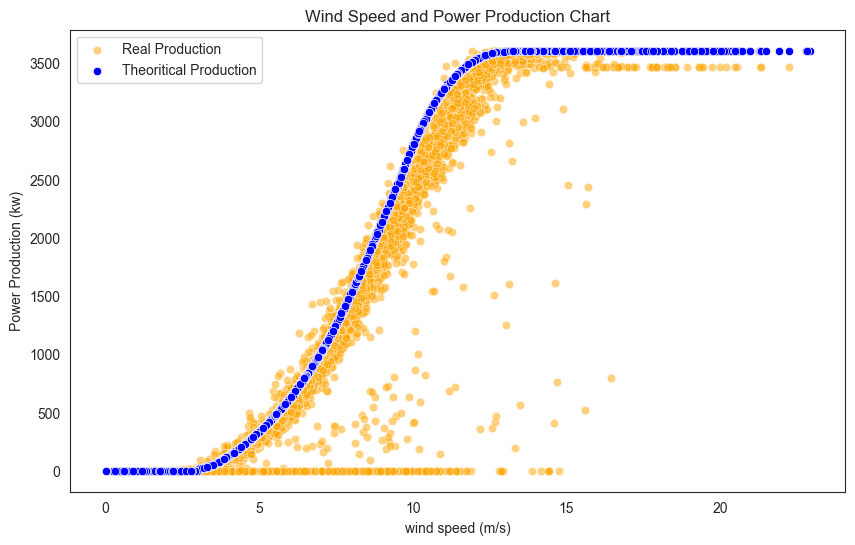

In [16]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='wind speed (m/s)', y='lv activepower (kw)', color='orange', label='Real Production', alpha=0.5, data=sample_df)
sns.scatterplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', color='blue', label='Theoritical Production', data=sample_df)
plt.title('Wind Speed and Power Production Chart')
plt.ylabel('Power Production (kw)');

**From the graph above, we can see the theoritical power production curve generally fits well with the real production.**

**We can see the power production reaches a maximum level and continues in a straight line if the wind speed reaches to 15 m/s.**


In [17]:
# Create a pandas df for visualization
wind_speed = spark_df.select('wind speed (m/s)').toPandas()

# Defining the quantiles and interquantile range
Q1 = wind_speed['wind speed (m/s)'].quantile(0.25)
Q2 = wind_speed['wind speed (m/s)'].quantile(0.5)
Q3 = wind_speed['wind speed (m/s)'].quantile(0.75)
Q4 = wind_speed['wind speed (m/s)'].quantile(1.0)
IQR = Q3-Q1
# Defining the lower and upper threshold values
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

### Question: Is there any other outliers?

In [18]:
# Fancy indexing for outliers
outlier_tf = (wind_speed['wind speed (m/s)'] < lower) | (wind_speed['wind speed (m/s)'] > upper)
print('Total Number of Outliers: ', len(wind_speed['wind speed (m/s)'][outlier_tf]))
print('--'*15)
print('Some Examples of Outliers:')
print(wind_speed['wind speed (m/s)'][outlier_tf])

Total Number of Outliers:  423
------------------------------
Some Examples of Outliers:
2396    19.59
2407    20.41
2408    20.31
2409    20.20
2410    21.74
         ... 
49499   20.89
49500   20.57
49501   20.45
49502   21.02
49503   20.43
Name: wind speed (m/s), Length: 423, dtype: float64


### Question: What are the general criterias for power production?

**It is important to understand the pattern in the data. We should learn the data before the machine.**

**1. We saw from the graph that in March, August and November, the average power production is higher.**

**2. The average power production is higher daily between 16:00 and 24:00.**

**3. The power production is higher when the wind blows from the directions between 000-090 and 180-225 degrees.**

**So let's try to predict a high and low level of power production from the criterias above before ML algorithm.**

In [19]:
# High level power production
spark_df.filter(((spark_df['month'] == 3) | (spark_df['month'] == 8) | (spark_df['month'] == 11)) 
                & ((spark_df['hour'] >= 16) | (spark_df['hour'] <= 24)) 
                & ((spark_df['wind direction (°)'] > 0) | (spark_df['wind direction (°)'] < 90))
                & ((spark_df['wind direction (°)'] > 180) | (spark_df['wind direction (°)'] < 225))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      1941.7172961020226|
+------------------------+



In [20]:
# Low level power production
spark_df.filter((spark_df['month'] == 7) 
                & ((spark_df['hour'] >= 9) | (spark_df['hour'] <= 11)) 
                & ((spark_df['wind direction (°)'] > 90) | (spark_df['wind direction (°)'] < 160))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|        477.014298326966|
+------------------------+



## Data Preparation for ML Algorithms

**After analysing and understanding the dataset, we can build a ML regression model to predict wind turbine power production by using the wind speed, wind direction, month of the year and hour of the day.**

**Using ML algorithms with Spark is a bit different from well known Sckitlearn library.**

**We need to feed the model with a dataframe made of variables compressed in vectors called as 'features', and target variable as 'label'. For these convertions I am going to use VectorAssembler method from Pyspark.**

In [21]:
# Preparing the independent variables (Features)
from pyspark.ml.feature import VectorAssembler

# Converting lv activepower (kw) variable as label
spark_df = spark_df.withColumn('label', spark_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(spark_df)

# Combining features and label column
final_df = va_df.select('features', 'label')
final_df.show(10)

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,0.0,5.311336...|380.047790527343|
|[1.0,0.0,5.672166...| 453.76919555664|
|[1.0,0.0,5.216036...|306.376586914062|
|[1.0,0.0,5.659674...|419.645904541015|
|[1.0,0.0,5.577940...|380.650695800781|
|[1.0,0.0,5.604052...|402.391998291015|
|[1.0,1.0,5.793007...|447.605712890625|
|[1.0,1.0,5.306049...|     387.2421875|
|[1.0,1.0,5.584629...|463.651214599609|
|[1.0,1.0,5.523228...|439.725708007812|
+--------------------+----------------+
only showing top 10 rows



## Train Test Split

**Now we can split our dataset into train and test datasets.**

In [22]:
splits = final_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

Train dataset:  40537
Test dataset :  9993


## Creating the Initial Model

**I am going to use GBT regressor for this study.**

In [23]:
from pyspark.ml.regression import GBTRegressor

# Creating the gbm regressor object
gbm = GBTRegressor(featuresCol='features', labelCol='label')

# Training the model with train data
gbm_model = gbm.fit(train_df)

# Predicting using the test data
y_pred = gbm_model.transform(test_df)

# Initial look at the target and predicted values
y_pred.select('label', 'prediction').show(20)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|             0.0|12.356362956742078|
|244.259399414062|166.52003190186016|
|270.477386474609|249.86539299037506|
|320.979614257812| 301.9401838482471|
| 346.68569946289|339.26697347755356|
|306.376586914062|339.26697347755356|
|368.497009277343|428.18166832678406|
| 453.76919555664|428.18166832678406|
|492.112487792968| 523.2832841156128|
|837.063720703125| 664.9526769249089|
|989.507690429687| 785.4216775955766|
|             0.0| 721.4171273410091|
|             0.0| 862.1817395478796|
|             0.0| 17.43373900707612|
|1878.79504394531|1977.7999131679007|
|893.031311035156| 66.60362564654426|
| 2292.5029296875|2196.0437177554954|
| 2295.8310546875| 2045.839617591966|
|2782.56811523437| 2543.686352360562|
|2947.68408203125| 2543.686352360562|
+----------------+------------------+
only showing top 20 rows



**Let's evaluate our model's success.**

In [24]:
# Initial model success
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.94463986420228
MAE      :  124.17828722215934
RMSE     :  307.7100992033443


**R2 score means, real power production's 97% variability can be explained by the ML model.**

**MAE is the mean absolute difference between the real and predicted power production.**

**RMSE is the square root of mean squared difference between the real and predicted values.**

**Even though the R2 is high, we should also check the MAE and RMSE values with the real value's summary statistics.**

**One can tune the hyperparameters to increase the model success. But I this look good enough for me.**

## Comparing Real, Theoritical and Predicted Power Productions

**I am going to use sample_df for comparing the actual, theoritical and the model power productions.**

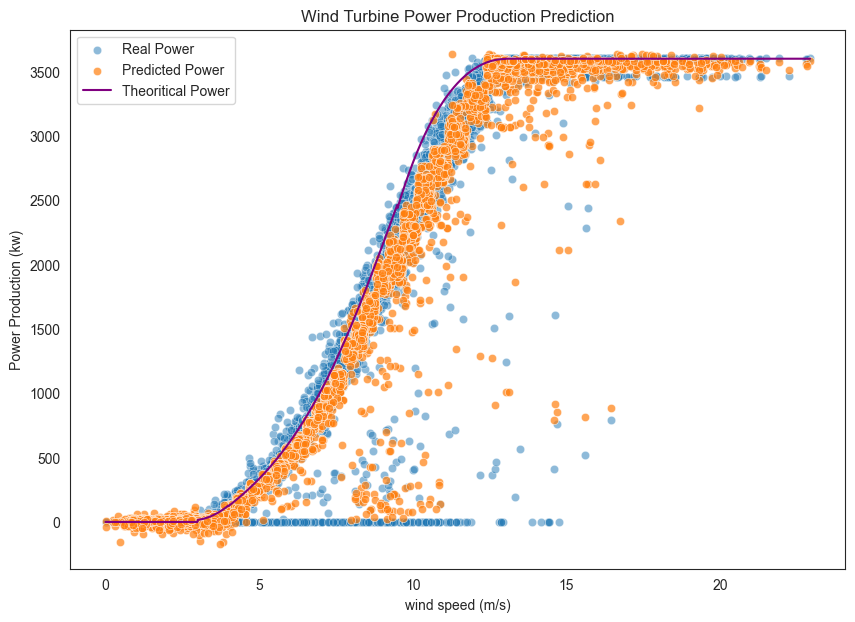

In [25]:
# Converting sample_df back to Spark dataframe
eva_df = spark.createDataFrame(sample_df)

# Converting lv activepower (kw) variable as label
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Combining features and label column
vec_df = vec_df.select('features', 'label')

# Using ML model to predict
preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();

**From the graph above, the model fits better to the real power productions, than the theoritical power production curve.**